# Первоначальный анализ входных данных

---

### Цели

1. Сформировать общее представление o датасете у всей команды. 
2. Оценить качество исходных данных для модели.
3. Наметить подход для дополнительной обработки данных в случае необходимости.

In [1]:
import json
import os
from multiprocessing import Pool
import sys
import matplotlib.pyplot as plt
from matplotlib import rcParams
import numpy as np
import pandas as pd
import pprint
import progressbar
import re
import requests
import questionary
import seaborn as sns
import statsmodels.api as sm
import time
import urllib
import warnings

In [2]:
plt.style.use('ggplot')
rcParams['font.family'] = 'monospace'
warnings.filterwarnings('ignore')
pd.options.display.max_columns = 50
pd.options.display.max_columns = 20
%matplotlib inline

In [3]:
BASE_DIR = os.path.dirname(os.path.dirname(os.path.abspath('__file__')))

##### Вся информация находится в 3-х файлах:
 - dataset_news_1.xlsx = факт просмотра пользователем новости с привязкой к дате
 - news.json = расширенная информация о новостях
 - districts.json = информация по округам г. Москвы

## Датасет

In [4]:
dataset = pd.read_excel(os.path.join(BASE_DIR, 'data', 'dataset_news_1.xlsx'))

#### Общая справка

In [5]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26446 entries, 0 to 26445
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   date_time  26446 non-null  datetime64[ns]
 1   url_clean  26446 non-null  object        
 2   user_id    26446 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 620.0+ KB


#### Посещаемость новостного портала

In [6]:
plt.style.use('ggplot')

In [7]:
users_per_hour = dataset.groupby(pd.Grouper(freq="1H", key="date_time"))['user_id'].count()

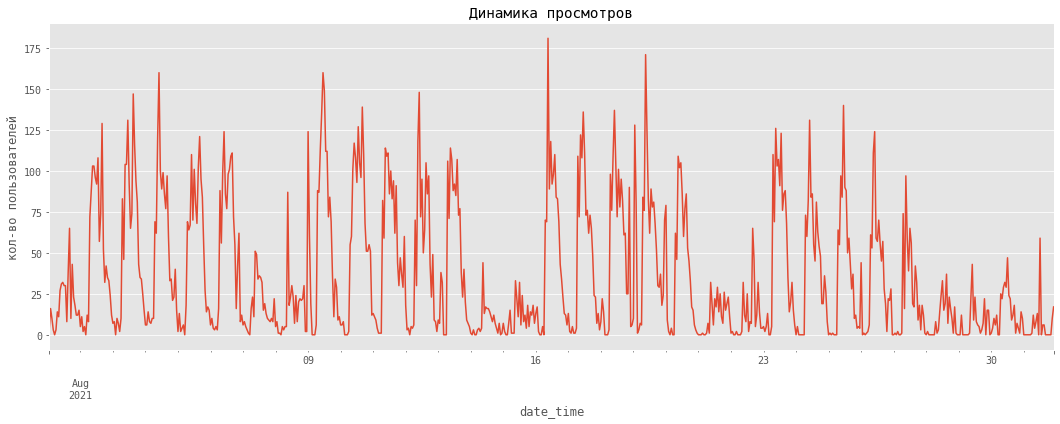

In [8]:
ax = users_per_hour.plot(title="Динамика просмотров", ylabel="кол-во пользователей", figsize=(18, 6))

##### Ожидаемые скачки в посещаемости днём и снижения ночью. Немного странно, что есть существенные "провалы" по выходным... Возможно это явление характерно для летнего периода, когда люди выходной стараются провести на природе/даче и т.д. Также, возможно это связано с какими-то особенностями аудитории новостного раздела. Надо поизучать.  Возможно стоит учесть этот момент для рекоммендательной модели. Например, на неделе фокус на услугах, полезной информации для определённого административного округа, политике.. а на выходных - культура, актуальные события и т.д.

#### Пользователи

In [9]:
# кол-во уникальных
dataset.user_id.nunique()

239

In [10]:
user_habbits = pd.pivot_table(data=dataset, values='url_clean', columns=pd.Grouper(key='date_time', freq='1D'), index='user_id', aggfunc="count", margins_name="Total")
user_habbits['days_active'] = [vals.count() for i, vals in user_habbits.iterrows()]
user_habbits['total_reads'] = [vals.sum() for i, vals in user_habbits.iterrows()]
user_habbits['avg_reads'] = user_habbits.total_reads / user_habbits.days_active

In [11]:
sns.set(rc={'font.family': 'monospace'})

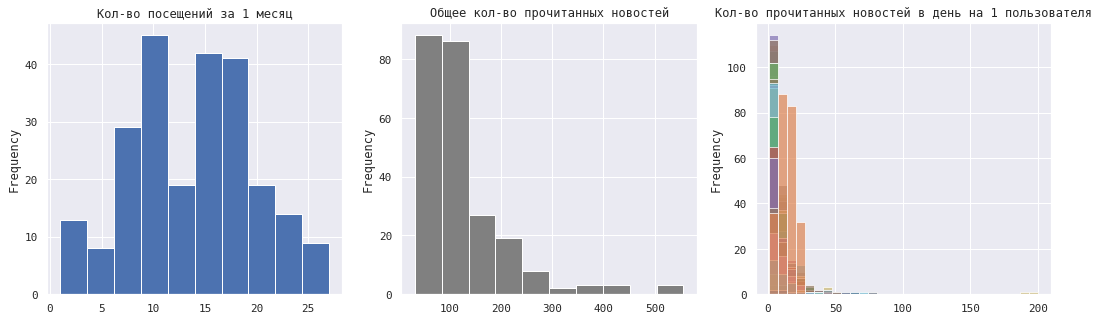

In [12]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(18, 5))
user_habbits['days_active'].plot(kind='hist', title='Кол-во посещений за 1 месяц', ax=ax[0])
user_habbits['total_reads'].plot(kind='hist', title='Общее кол-во прочитанных новостей', ax=ax[1], color='grey')
user_habbits.iloc[:, :-2].plot(kind='hist', title='Кол-во прочитанных новостей в день на 1 пользователя', ax=ax[2], legend=False, alpha=0.7, bins=30)
plt.show()

##### Пока не очень ясно как можно это прокомментировать... 
1. Люди заходят, некоторые очень даже регулярно. 
2. при этом, обычно просматривают меньше 10 новостей.
3. интересно будет посмотреть сколько они проводят времени на сайте.

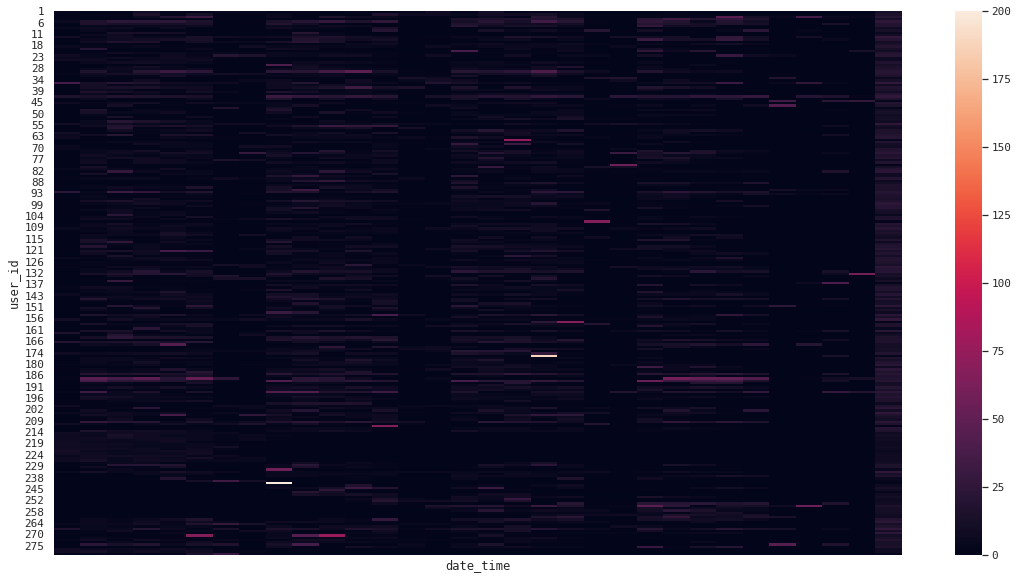

In [13]:
fig, ax = plt.subplots(figsize=(19,10))
ax = sns.heatmap(user_habbits.iloc[:, :-2].fillna(0), xticklabels=False)

##### Есть и те, для кого не бывает "слишком много новостей". Но их немного

## Новости

In [14]:
df_news = pd.read_json(os.path.join(BASE_DIR, 'data', 'news.json'))

In [15]:
df_news.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6554 entries, 0 to 6553
Data columns (total 48 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   id                       6554 non-null   int64         
 1   title                    6554 non-null   object        
 2   importance               4673 non-null   object        
 3   published_at             6554 non-null   datetime64[ns]
 4   created_at               6554 non-null   datetime64[ns]
 5   updated_at               6554 non-null   datetime64[ns]
 6   is_deferred_publication  5729 non-null   float64       
 7   status                   6554 non-null   object        
 8   ya_rss                   6554 non-null   int64         
 9   active_from              0 non-null      float64       
 10  active_to                0 non-null      float64       
 11  oiv_id                   5714 non-null   float64       
 12  search                   6554 non-

In [16]:
with open(os.path.join(BASE_DIR, 'data/news.json'), 'r') as file:
    news = json.loads(file.read())

In [17]:
# пример одной новости
pprint.pprint(news[1])

{'active_from': None,
 'active_from_timestamp': False,
 'active_to': None,
 'active_to_timestamp': False,
 'attach': [],
 'canonical_updated_at': '2021-09-21 12:52:45',
 'canonical_url': None,
 'counter': None,
 'created_at': '2020-09-25 16:49:20',
 'created_at_timestamp': 1601041760,
 'date': '2020-09-26 09:02:00',
 'date_timestamp': '1601100120',
 'display_image': 1,
 'full_text': '<p>С 26 сентября по 5 октября закрылся участок '
              'Арбатско-Покровской линии от станции метро '
              '&laquo;Молодежная&raquo; до &laquo;Парка Победы&raquo;. Для '
              'пассажиров организованы компенсационные автобусы (КМ).</p>\n'
              '<p>Они следуют от &laquo;Молодежной&raquo; через '
              '&laquo;Кунцевскую&raquo; и &laquo;Славянский бульвар&raquo; до '
              '&laquo;Парка Победы&raquo;. С 05:00 до 01:55 будут курсировать '
              '132 автобуса КМ с интервалами в час пик около одной минуты и в '
              'районе двух минут в течение д

In [18]:
",".join(df_news.columns)

'id,title,importance,published_at,created_at,updated_at,is_deferred_publication,status,ya_rss,active_from,active_to,oiv_id,search,display_image,label,icon_id,canonical_url,canonical_updated_at,is_powered,has_image,date,has_district,date_timestamp,tags,theme_id,theme_ids,themes,spheres,sphere,kind,is_oiv_publication,organizations,updated_at_timestamp,created_at_timestamp,attach,active_from_timestamp,active_to_timestamp,image,counter,territory_area_id,territory_district_id,preview_text,full_text,url,preview,text,promo,images'

### Категории

In [19]:
df_news.describe(include=['object']).T

,count,unique,top,freq
title,6554,6485,Оперштаб сообщил о новых случаях коронавируса,24
importance,4673,1,,4673
status,6554,2,public,5517
label,115,57,Кино,11
tags,6554,6099,"[{'id': 989217, 'title': 'статистика', 'create...",81
theme_ids,6554,77,[],5506
themes,6554,77,[],5506
spheres,6554,1408,"[{'id': 12299, 'title': 'Экономика и предприни...",512
sphere,6554,62,"{'id': 3299, 'title': 'Культура', 'special': 0...",937
kind,6554,2,"{'id': 'article', 'title': 'Новости', 'type': 1}",5729


небольшое количество записей содержит информацию в колонках preview, text, images. При этом, у нас есть колонки со схожими названиями: preview_text, full_text, image.

### Значения, даты, булеаны

In [20]:
df_news.describe(exclude=[object]).T

,count,unique,top,freq,first,last,mean,std,min,25%,50%,75%,max
id,6554.0,NaN,NaT,NaN,NaT,NaT,71433788.597345,29949637.36862,179050.0,61164573.0,85685573.0,93104573.0,95391073.0
published_at,6554,6453,2021-01-26 07:01:01,3,2011-08-29 19:42:00,2021-08-31 18:47:56,NaN,NaN,NaN,NaN,NaN,NaN,NaN
created_at,6554,6552,2021-07-05 15:09:29,2,2012-05-16 15:51:33,2021-08-31 18:19:54,NaN,NaN,NaN,NaN,NaN,NaN,NaN
updated_at,6554,4898,2020-06-11 19:33:47,1368,2020-06-11 19:33:41,2021-09-21 08:21:39,NaN,NaN,NaN,NaN,NaN,NaN,NaN
is_deferred_publication,5729.0,NaN,NaT,NaN,NaT,NaT,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ya_rss,6554.0,NaN,NaT,NaN,NaT,NaT,0.662344,0.472947,0.0,0.0,1.0,1.0,1.0
active_from,0.0,NaN,NaT,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
active_to,0.0,NaN,NaT,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
oiv_id,5714.0,NaN,NaT,NaN,NaT,NaT,8718689.00245,17115937.4935,0.0,0.0,0.0,19343090.0,103466090.0
search,6554.0,NaN,NaT,NaN,NaT,NaT,0.99939,0.024699,0.0,1.0,1.0,1.0,1.0


In [21]:
# проверим несколько записей с пустыми значениями в столбце preview
df_news[df_news.preview.isna()][['preview', 'preview_text', 'text', 'full_text', 'image', 'images']][:5]

,preview,preview_text,text,full_text,image,images
0,NaN,Электронное голосование доступно для граждан Р...,NaN,"<p>На порталах <a href=""https://www.mos.ru/pgu...","{'id': 2712459281, 'title': '', 'copyright': '...",NaN
1,NaN,Они будут следовать от станции метро «Молодежн...,NaN,<p>С 26 сентября по 5 октября закрылся участок...,"{'id': 2827575281, 'title': 'Ю. Иванко. Mos.ru...",NaN
2,NaN,"Арина Аверина победила с результатом 79,250 ба...",NaN,<p>Московские спортсменки Арина и Дина Аверины...,"{'id': 1445509281, 'title': '', 'copyright': '...",NaN
3,NaN,Новое здание появится на Волгоградском проспекте.,NaN,"<p style=""text-align: justify;"">На юго-востоке...","{'id': 3289674281, 'title': '', 'copyright': '...",NaN
4,NaN,"Фаина Рублева — о новейших технологиях, подаре...",NaN,<p>5 ноября 1929 года в Москве открылся первый...,"{'id': 2269164281, 'title': '', 'copyright': '...",NaN


In [22]:
# проверим несколько записей с пустыми значениями в столбце preview_text
df_news[df_news.preview_text.isna()][['preview', 'preview_text', 'text', 'full_text', 'image', 'images']][:5]

,preview,preview_text,text,full_text,image,images
5729,"Город развивается, перенимая опыт передовых ме...",NaN,<p>Москва не должна идти по пути вытеснения из...,NaN,"{'id': 1111291281, 'title': '', 'copyright': '...","[{'id': 1111291281, 'title': '', 'copyright': ..."
5730,"Общий объем заявок на покупку составил 79,3 ми...",NaN,<p>Москва успешно разместила трехлетние облига...,NaN,"{'id': 3071163281, 'title': 'Фото М. Мишина. П...","[{'id': 3071163281, 'title': 'Фото М. Мишина. ..."
5731,На встрече обсуждалась подготовка к съезду пар...,NaN,"<p class=""p1"">В Музее Победы на Поклонной горе...",NaN,"{'id': 3288955281, 'title': 'Фото М. Мишина. П...","[{'id': 3288955281, 'title': 'Фото М. Мишина. ..."
5732,Там можно организовать рабочие места консьерже...,NaN,<p>Правительство столицы откажется от права со...,NaN,"{'id': 3019749281, 'title': 'Фото Е. Самарина....","[{'id': 3019749281, 'title': 'Фото Е. Самарина..."
5733,Часть столичных отраслей уже достигла показате...,NaN,<p>Москва второй год подряд становится лидером...,NaN,"{'id': 2741641281, 'title': '', 'copyright': '...","[{'id': 2741641281, 'title': '', 'copyright': ..."


In [23]:
string_columns = df_news.select_dtypes(object).columns

In [24]:
string_columns

Index(['title', 'importance', 'status', 'label', 'tags', 'theme_ids', 'themes',
       'spheres', 'sphere', 'kind', 'organizations', 'attach', 'image',
       'preview_text', 'full_text', 'url', 'preview', 'text', 'images'],
      dtype='object')

In [25]:
val_columns = df_news.select_dtypes(exclude=object).columns

In [26]:
val_columns

Index(['id', 'published_at', 'created_at', 'updated_at',
       'is_deferred_publication', 'ya_rss', 'active_from', 'active_to',
       'oiv_id', 'search', 'display_image', 'icon_id', 'canonical_url',
       'canonical_updated_at', 'is_powered', 'has_image', 'date',
       'has_district', 'date_timestamp', 'theme_id', 'is_oiv_publication',
       'updated_at_timestamp', 'created_at_timestamp', 'active_from_timestamp',
       'active_to_timestamp', 'counter', 'territory_area_id',
       'territory_district_id', 'promo'],
      dtype='object')

In [27]:
df_news[string_columns] = df_news[string_columns].fillna('')

In [28]:
df_news[val_columns] = df_news[val_columns].fillna(0)

In [29]:
df_news

,id,title,importance,published_at,created_at,updated_at,is_deferred_publication,status,ya_rss,active_from,...,counter,territory_area_id,territory_district_id,preview_text,full_text,url,preview,text,promo,images
0,75178073,Открыта запись на электронное голосование по и...,,2020-06-05 09:00:00,2020-06-04 22:14:43,2020-06-24 09:11:55,0.0,public,1,0.0,...,0.0,0.0,0.0,Электронное голосование доступно для граждан Р...,"<p>На порталах <a href=""https://www.mos.ru/pgu...",/news/item/75178073/,,,0.0,
1,80375073,Для пассажиров закрытого участка Арбатско-Покр...,,2020-09-26 09:04:00,2020-09-25 16:49:20,2020-09-26 09:04:00,0.0,public,1,0.0,...,0.0,73501.0,6500.0,Они будут следовать от станции метро «Молодежн...,<p>С 26 сентября по 5 октября закрылся участок...,/news/item/80375073/,,,0.0,
2,41116073,Москвичка Арина Аверина выиграла чемпионат Евр...,,2018-06-04 12:04:00,2018-06-04 09:51:15,2020-06-11 19:33:47,0.0,public,0,0.0,...,0.0,0.0,0.0,"Арина Аверина победила с результатом 79,250 ба...",<p>Московские спортсменки Арина и Дина Аверины...,/news/item/41116073/,,,0.0,
3,94978073,Многофункциональный комплекс со спортивными и ...,,2021-08-23 09:23:51,2021-08-23 09:07:27,2021-08-23 09:23:01,0.0,public_oiv,0,0.0,...,0.0,119501.0,9500.0,Новое здание появится на Волгоградском проспекте.,"<p style=""text-align: justify;"">На юго-востоке...",/news/item/94978073/,,,0.0,
4,64742073,«По масштабам Вселенной 90 лет — это миг». Инт...,,2019-11-05 10:00:00,2019-11-01 21:28:46,2021-01-22 13:50:55,0.0,public,1,0.0,...,0.0,6501.0,1500.0,"Фаина Рублева — о новейших технологиях, подаре...",<p>5 ноября 1929 года в Москве открылся первый...,/news/item/64742073/,,,0.0,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6549,7163050,Сергей Собянин предложил москвичам рассказать ...,,2021-02-23 18:34:01,2021-02-23 15:44:28,2021-02-23 18:33:00,0.0,public,1,0.0,...,0.0,0.0,0.0,,,/mayor/themes/231299/7163050/,Истории горожан о столичных домах и монументах...,"<p><a href=""https://www.mos.ru/mayor/biography...",0.0,"[{'id': 2976833281, 'title': 'Маскировка здани..."
6550,6965050,Сборная Москвы стала победителем VI Национальн...,,2020-11-29 17:47:00,2020-11-29 17:38:17,2020-11-29 17:50:22,0.0,public,1,0.0,...,0.0,0.0,0.0,,,/mayor/themes/1299/6965050/,Проект помогает участниками — молодым людям с ...,<p>Сборная столицы завоевала 108 наград на VI ...,0.0,"[{'id': 2888072281, 'title': '', 'copyright': ..."
6551,5484050,Сергей Собянин: Московское здравоохранение вый...,,2019-03-13 23:15:00,2019-03-13 23:09:38,2020-06-11 19:33:41,0.0,public,1,0.0,...,0.0,0.0,0.0,,,/mayor/themes/18299/5484050/,Столичная медицина должна стать еще более паци...,<p>Развивать здравоохранение необходимо по все...,0.0,"[{'id': 1898890281, 'title': '', 'copyright': ..."
6552,7239050,Две поликлиники в районах Котловка и Кузьминки...,,2021-03-29 16:48:00,2021-03-29 16:34:53,2021-03-31 15:50:57,0.0,public,1,0.0,...,0.0,0.0,0.0,,,/mayor/themes/4299/7239050/,Всего по новому стандарту планируется отремонт...,<p>Поликлиники в районах Котловка и Кузьминки ...,0.0,"[{'id': 3018310281, 'title': 'Фото В. Новикова..."


 MEMO: перенести данные в одну колонку: preview -> preview_text, text -> full_text, images -> image

In [30]:
df_news.preview_text = df_news.apply(lambda c: c.preview if len(c.preview) > 0 else c.preview_text, axis=1)

In [31]:
df_news.full_text = df_news.apply(lambda c: c.text if len(c.text) > 0 else c.full_text, axis=1)

### Сверка наличия необходимых id в датасетах

In [32]:
dataset['news_id'] = [int(str(i[-1]).strip()) for i in dataset.url_clean.str.findall(r"(\d{4,})")]

In [33]:
dataset.news_id.fillna(0, inplace=True)

In [34]:
df_news[~df_news.id.isin(dataset.news_id.unique())][['id', 'title', 'preview_text', 'created_at', 'published_at', 'updated_at']]

,id,title,preview_text,created_at,published_at,updated_at
10,91359073,Москва окажет финансовую поддержку анимационны...,Город выделил 100 миллионов рублей на стимулир...,2021-05-27 17:18:38,2021-05-28 09:01:00,2021-05-28 12:21:05
11,95361073,Планируйте маршрут: на Савеловском и Белорусск...,Изменения связаны с проведением путевых работ.,2021-08-31 11:55:25,2021-08-31 12:01:00,2021-08-31 12:00:44
32,79697073,В Южном Бутове построят детский сад,"В здании будут кабинеты логопеда и психолога, ...",2020-09-10 18:01:55,2020-09-10 20:11:01,2020-09-10 20:11:01
37,87907073,Экскурсии и квесты: день открытых дверей в биб...,В 130 читальнях и 76 культурных центрах можно ...,2021-03-16 20:50:35,2021-03-17 09:01:03,2021-03-17 09:00:26
40,58340073,1500 цветников ко Дню города: фестиваль «Цвето...,Создать авторский цветник смогут все желающие....,2019-07-08 11:38:20,2019-07-08 13:04:00,2020-06-11 19:33:47
...,...,...,...,...,...,...
6499,7401050,Москва стала лидером Национального рейтинга со...,Большинство отраслей бизнеса в Москве после пи...,2021-06-04 13:36:44,2021-06-04 13:47:00,2021-06-04 13:46:03
6508,7267050,В столице определили победителей конкурса «Учи...,Всего в конкурсе приняли участие 720 учителей ...,2021-04-12 20:26:16,2021-04-12 20:33:00,2021-04-12 20:32:33
6509,7503050,Образовательный туризм: Москва подписала Согла...,В рамках Соглашения школьники из Москвы смогут...,2021-07-16 17:46:23,2021-07-16 17:52:00,2021-07-16 17:51:38
6527,5602050,Новые музыкальные инструменты и отремонтирован...,Всего в рамках проекта «Искусство — детям» пла...,2019-04-24 17:46:20,2019-04-24 18:19:00,2020-06-11 19:33:41


##### Предоставленные данные с новостям содержат больше информации, чем есть в датасете. При обратном поиске не удалось найти 3 значения.

In [35]:
set(dataset.news_id.unique()).difference(set(df_news.id.unique()))

{9468, 9514707, 94855073}

## Работа с объединёнными массивами

In [36]:
# для дальнейшего анализа оставим следующие поля как наиболее полные и вероятно в будущем полезные
key_fields = ['id', 'created_at', 'published_at', 'status', 'kind', 'title', 'preview_text', 'tags', 'url', 'sphere', 'spheres', 'label']

In [37]:
df_mod = df_news[key_fields]

In [38]:
df_fin = pd.merge(dataset, df_mod, left_on='news_id', right_on='id', how='left')

In [39]:
df_fin.head()

,date_time,url_clean,user_id,news_id,id,created_at,published_at,status,kind,title,preview_text,tags,url,sphere,spheres,label
0,2021-08-01 18:51:19,mos.ru/news/item/94006073/,1,94006073,94006073.0,2021-07-30 07:29:53,2021-08-01 09:04:00,public,"{'id': 'article', 'title': 'Новости', 'type': 1}",Дома-порталы: где в Москве можно почувствовать...,"Распутываем лепные кружева, ищем кошку на эрке...","[{'id': 144217, 'title': 'архитектура', 'creat...",/news/item/94006073/,"{'id': 3299, 'title': 'Культура', 'special': 0...","[{'id': 3299, 'title': 'Культура', 'special': ...",
1,2021-08-01 18:57:28,mos.ru/news/item/94000073/,1,94000073,94000073.0,2021-07-29 20:24:21,2021-07-30 10:01:00,public,"{'id': 'article', 'title': 'Новости', 'type': 1}",Чтобы дома было комфортно: какие вопросы помог...,За три десятка лет ведомство значительно упрос...,"[{'id': 17217, 'title': 'перепланировка', 'cre...",/news/item/94000073/,"{'id': 5299, 'title': 'Городское хозяйство', '...","[{'id': 5299, 'title': 'Городское хозяйство', ...",
2,2021-08-04 08:49:49,mos.ru/news/item/94062073/,1,94062073,94062073.0,2021-07-30 18:46:26,2021-08-02 07:05:00,public,"{'id': 'article', 'title': 'Новости', 'type': 1}",Полярные совы в Московском зоопарке обзавелись...,"Пока крохи мало походят на родителей, они покр...","[{'id': 33217, 'title': 'культура', 'created_a...",/news/item/94062073/,"{'id': 3299, 'title': 'Культура', 'special': 0...","[{'id': 3299, 'title': 'Культура', 'special': ...",
3,2021-08-04 08:49:49,mos.ru/news/item/94063073/,1,94063073,94063073.0,2021-07-30 19:31:31,2021-08-02 07:04:01,public,"{'id': 'article', 'title': 'Новости', 'type': 1}",В Москве начали производить лифты с системой б...,Специальный контроллер примет сигнал мобильног...,"[{'id': 331217, 'title': 'технологии', 'create...",/news/item/94063073/,"{'id': 183299, 'title': 'Технологии', 'special...","[{'id': 183299, 'title': 'Технологии', 'specia...",
4,2021-08-04 08:49:57,mos.ru/news/item/93893073/,1,93893073,93893073.0,2021-07-27 18:14:47,2021-08-02 07:02:00,public,"{'id': 'article', 'title': 'Новости', 'type': 1}",Любовь и звери: как разводят редких животных в...,"Женить леопарда, воспитать птенцов дрофы и выс...","[{'id': 460217, 'title': 'зоопарк', 'created_a...",/news/item/93893073/,"{'id': 301299, 'title': 'Животные', 'special':...","[{'id': 301299, 'title': 'Животные', 'special'...",


In [40]:
df_fin[df_fin.created_at.isna()]

,date_time,url_clean,user_id,news_id,id,created_at,published_at,status,kind,title,preview_text,tags,url,sphere,spheres,label
7465,2021-08-27 13:03:12,mos.ru/news/item/9514707/,71,9514707,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9032,2021-08-30 07:07:27,mos.ru/news/item/94855073/,90,94855073,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12588,2021-08-18 10:43:39,mos.ru/news/item/9468/,131,9468,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19842,2021-08-30 07:05:08,mos.ru/news/item/94855073/,193,94855073,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [41]:
df_fin.dropna(inplace=True)

In [42]:
df_fin['kind'] = df_fin.kind.apply(lambda s: s.get('title', ''))

In [43]:
df_fin['sphere'] = df_fin.sphere.apply(lambda s: s.get('title', ''))

In [45]:
df_fin['spheres'] = df_fin.spheres.apply(lambda s: [i.get('title', '') for i in s])

In [46]:
df_fin.drop(columns=['id'], inplace=True)

In [47]:
df_fin.head()

,date_time,url_clean,user_id,news_id,created_at,published_at,status,kind,title,preview_text,tags,url,sphere,spheres,label
0,2021-08-01 18:51:19,mos.ru/news/item/94006073/,1,94006073,2021-07-30 07:29:53,2021-08-01 09:04:00,public,Новости,Дома-порталы: где в Москве можно почувствовать...,"Распутываем лепные кружева, ищем кошку на эрке...","[{'id': 144217, 'title': 'архитектура', 'creat...",/news/item/94006073/,Культура,"[Культура, Мой район, История Москвы, Уникальн...",
1,2021-08-01 18:57:28,mos.ru/news/item/94000073/,1,94000073,2021-07-29 20:24:21,2021-07-30 10:01:00,public,Новости,Чтобы дома было комфортно: какие вопросы помог...,За три десятка лет ведомство значительно упрос...,"[{'id': 17217, 'title': 'перепланировка', 'cre...",/news/item/94000073/,Городское хозяйство,[Городское хозяйство],
2,2021-08-04 08:49:49,mos.ru/news/item/94062073/,1,94062073,2021-07-30 18:46:26,2021-08-02 07:05:00,public,Новости,Полярные совы в Московском зоопарке обзавелись...,"Пока крохи мало походят на родителей, они покр...","[{'id': 33217, 'title': 'культура', 'created_a...",/news/item/94062073/,Культура,"[Культура, Мой район, Животные, Комфорт: Досуг...",
3,2021-08-04 08:49:49,mos.ru/news/item/94063073/,1,94063073,2021-07-30 19:31:31,2021-08-02 07:04:01,public,Новости,В Москве начали производить лифты с системой б...,Специальный контроллер примет сигнал мобильног...,"[{'id': 331217, 'title': 'технологии', 'create...",/news/item/94063073/,Технологии,[Технологии],
4,2021-08-04 08:49:57,mos.ru/news/item/93893073/,1,93893073,2021-07-27 18:14:47,2021-08-02 07:02:00,public,Новости,Любовь и звери: как разводят редких животных в...,"Женить леопарда, воспитать птенцов дрофы и выс...","[{'id': 460217, 'title': 'зоопарк', 'created_a...",/news/item/93893073/,Животные,[Животные],


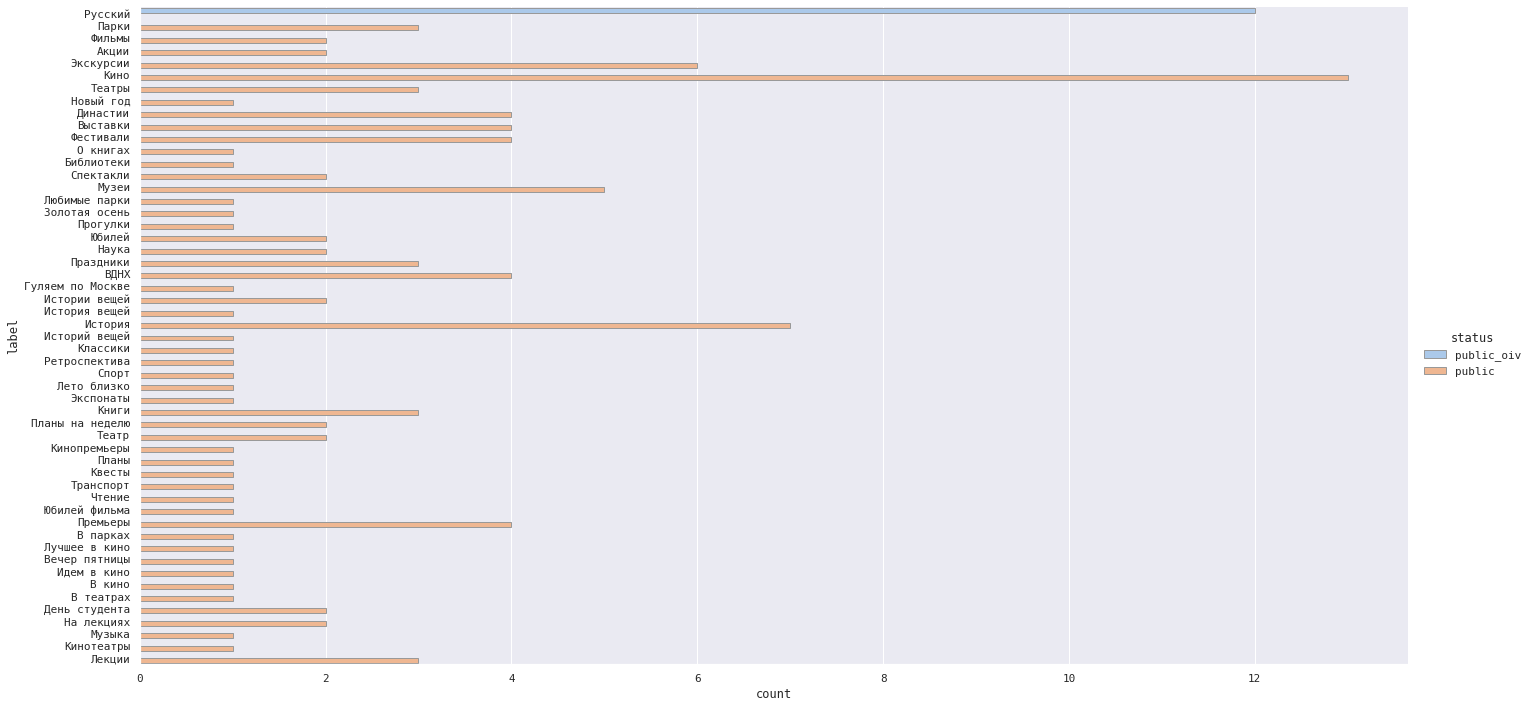

In [48]:
# fig, ax = plt.subplots(figsize=(22,7))
sns.catplot(y="label", hue="status", kind="count",
            palette="pastel", edgecolor=".6", 
            data=df_fin[df_fin.label != ''], height=10, aspect=2)
# plt.show()

In [49]:
date_time_cols = ['date_time', 'created_at', 'published_at']

In [50]:
df_fin[date_time_cols] = df_fin[date_time_cols].apply(lambda col: pd.to_datetime(col))

In [51]:
df_fin['marker'] = [1 for i in range(df_fin.shape[0])]

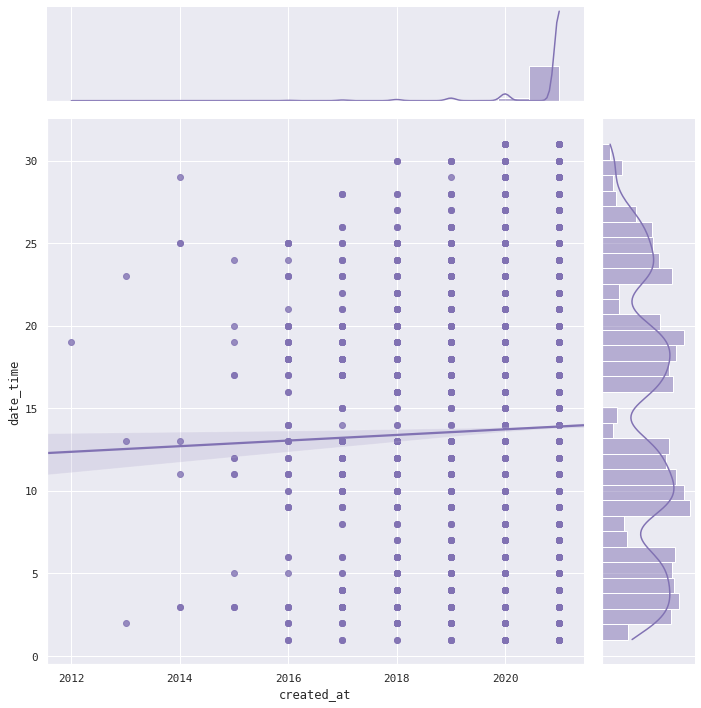

In [66]:
g = sns.jointplot(x=df_fin.created_at.dt.year,
                  y=df_fin.date_time.dt.day,
                  data=df_fin,
                  kind="reg",
                  truncate=False,
#                   xlim=(df_fin.created_at.min(), df_fin.created_at.max()), ylim=(df_fin.date_time.min(), df_fin.date_time.max()),
                  color="m",
                  height=10
                 )